# Import & Check GPU

In [1]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from transformers import SegformerForSemanticSegmentation

from Tools.DataGenerator import CSDataset
import Tools.Utils as utils
from Models.Unet import UNet
#from Models.SegFormer_custom import SegFormer
#from Models.SegFormer_custom2 import SegFormer2
from Models.Models_Utils import *

import warnings
warnings.filterwarnings('ignore')

d:\Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#sns.set_style()

In [3]:
#https://pytorch.org/get-started/locally/
#https://pytorch.org/get-started/previous-versions/
#pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu118

print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

gpu_number = torch.cuda.device_count()
print('GPU is available:', gpu_number > 0)
if gpu_number > 0:
    print('Torch GPU count:', gpu_number)
    for ind in range(gpu_number):
        print("*"*20)
        print("GPU {}:".format(ind))
        print("Device name:", torch.cuda.get_device_name(ind))
        print("Compute capability:", torch.cuda.get_device_capability(ind))
        print("Memory:", torch.cuda.get_device_properties(ind).total_memory/1024/1024, "MB")

Torch version: 2.4.0+cu124
Torch is build with CUDA: True
Torch device : cuda
------------------------------
GPU is available: True
Torch GPU count: 1
********************
GPU 0:
Device name: NVIDIA GeForce RTX 2070 with Max-Q Design
Compute capability: (7, 5)
Memory: 8191.6875 MB


In [4]:
utils.init()

In [5]:
SAMPLE_SIZE = 1
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 2
EPOCHS = 20

# EDA

CityScape available here : https://www.cityscapes-dataset.com/

In [6]:
dict_path = f'./Data/full_dict.json'

with open(dict_path) as f:
    data = f.read()
    full_dict = json.loads(data)

Scale sample size (for iteration purpose)

In [7]:
for n in ['train', 'val', 'test']:
    for key in full_dict[n].keys() :
            full_dict[n][key] = full_dict[n][key][:int(len(full_dict[n][key]) * SAMPLE_SIZE)]

In [8]:
df_train = pd.DataFrame(full_dict['train'])
df_val = pd.DataFrame(full_dict['val'])
df_test = pd.DataFrame(full_dict['test'])

In [9]:
df_train.shape, df_val.shape, df_test.shape

((2953, 10), (261, 10), (261, 10))

## Cities distribution :

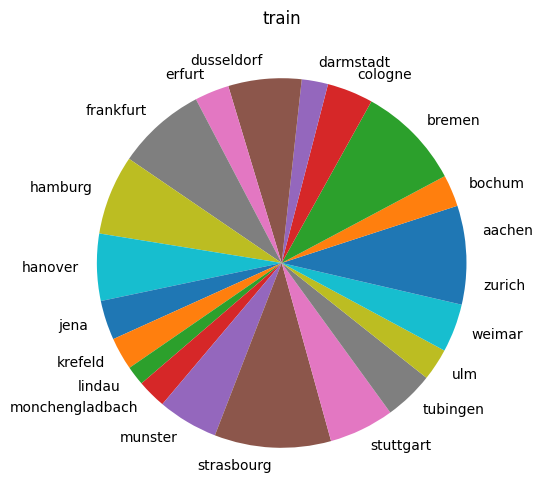

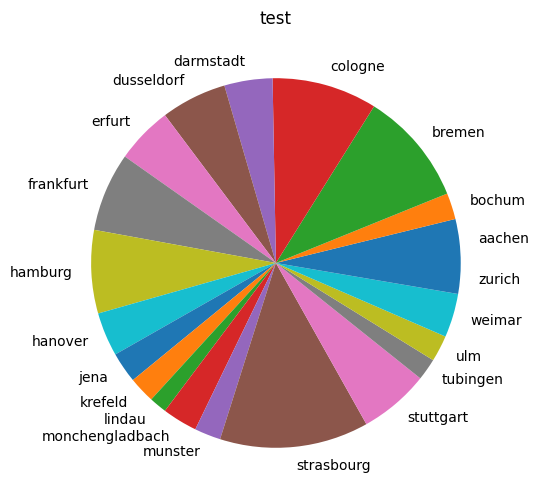

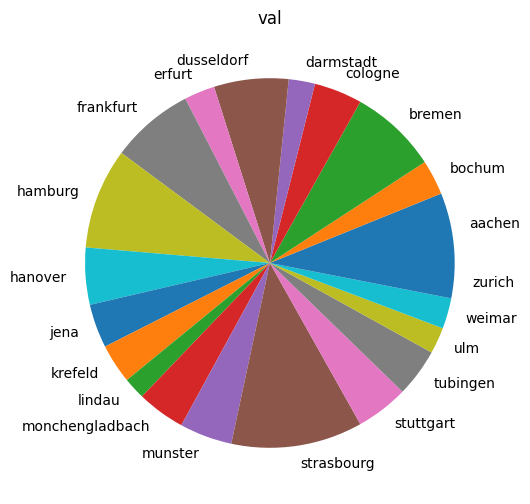

In [10]:
for name, df in [('train', df_train), ('test', df_test), ('val', df_val)] :
    aggr = df.groupby(by='city').agg(count=('ID', 'count'))
    aggr = aggr.reset_index()
    plt.figure(figsize=(6,6))
    plt.pie(aggr['count'], labels=aggr['city'])
    plt.title(name)
    plt.show()

## Categories Distribution :

Let's take a look at the distribution of each categories per images but also per pixel :

Per images :

In [11]:
IGNORE_distrib = True

In [12]:
list = ['train', 'val', 'test']

total = np.zeros(len(utils.classes))

nb_images = 0

if not IGNORE_distrib :
    for tvt in list :
        current_set = full_dict[tvt]
        for mask_path in current_set['labelID_path'] :
            local_count = np.zeros(len(utils.classes))
            img_mask = torchvision.io.read_image(mask_path, torchvision.io.ImageReadMode.GRAY) #ImageReadMode.RGB #ImageReadMode.GRAY
            T = torchvision.transforms.Resize((IMAGE_SIZE[0], IMAGE_SIZE[1]), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
            img_mask = T(img_mask)
            mask_array = img_mask.numpy()
            mask_array = np.squeeze(mask_array)

            mask = np.zeros((mask_array.shape[0], mask_array.shape[1], len(utils.classes)))
            for i in range(-1, 34):
                for idx, cat_name in enumerate(utils.classes):
                    if i in utils.categories[cat_name]:
                        mask[:,:,idx]=np.logical_or(mask[:,:,idx], (mask_array==i))
            mask = np.argmax(mask, axis=-1) 
            mask = np.expand_dims(mask, axis=-1)
            #Here we have a mask of shape (img_size,img_size) containning the category number for each pixel
            uniques, counts = np.unique(mask, return_counts=True) # number of pixel per category

            for id, count in zip(uniques, counts) :
                local_count[id] = count

            total += local_count / (IMAGE_SIZE[0] * IMAGE_SIZE[1])

            nb_images += 1
    total = total / nb_images

In [13]:
if not IGNORE_distrib :
    dict_count = dict(zip(utils.classes, total))
    df = pd.DataFrame.from_dict(dict_count, orient='index', columns=['count']).reset_index()

In [14]:
df.to_csv("distribution.csv", index=False)

In [15]:
if not IGNORE_distrib :
    plt.figure(figsize=(6,6))
    plt.pie(df['count'], labels=df['index'], autopct='%1.1f%%')
    plt.title("Total Categories distributions per pixels")
    plt.show()

## Datasets and examples

Create Dataset

In [16]:
dat_train = CSDataset(full_dict['train'], IMAGE_SIZE, augmentation=None)
dat_val = CSDataset(full_dict['val'], IMAGE_SIZE, augmentation=None)
dat_test = CSDataset(full_dict['test'], IMAGE_SIZE, augmentation=None)

load_train = DataLoader(dat_train, batch_size=BATCH_SIZE)
load_val = DataLoader(dat_val, batch_size=BATCH_SIZE)
load_test = DataLoader(dat_test, batch_size=BATCH_SIZE)

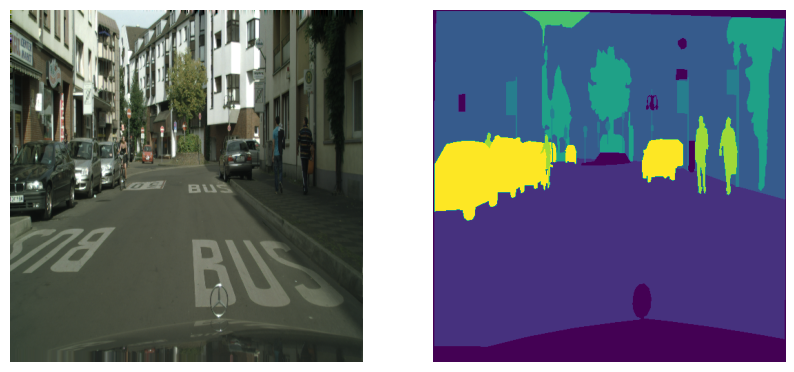

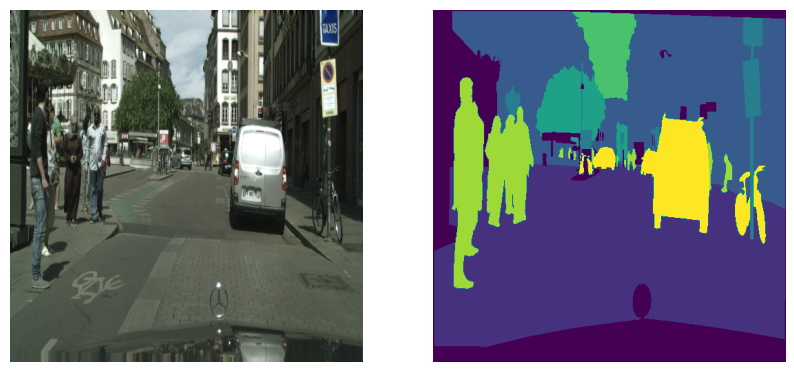

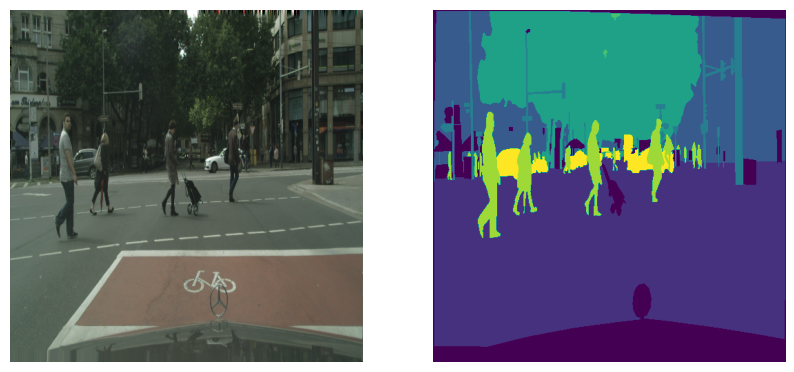

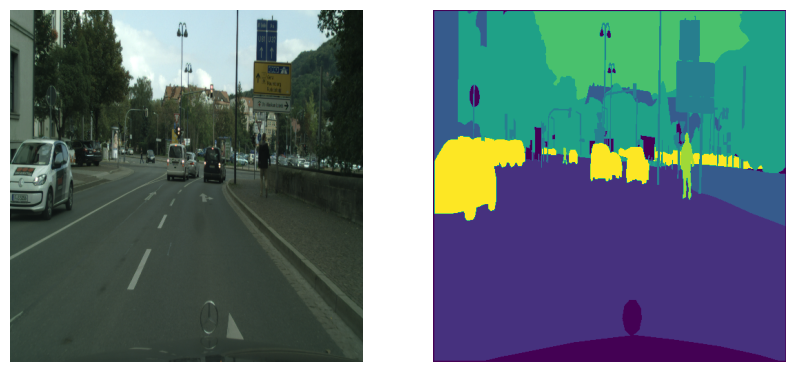

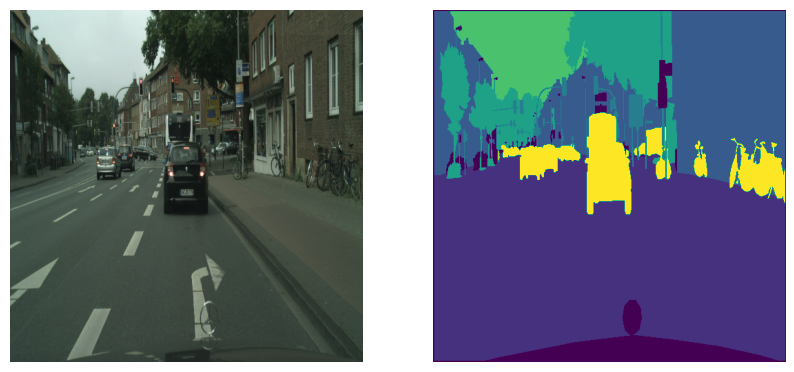

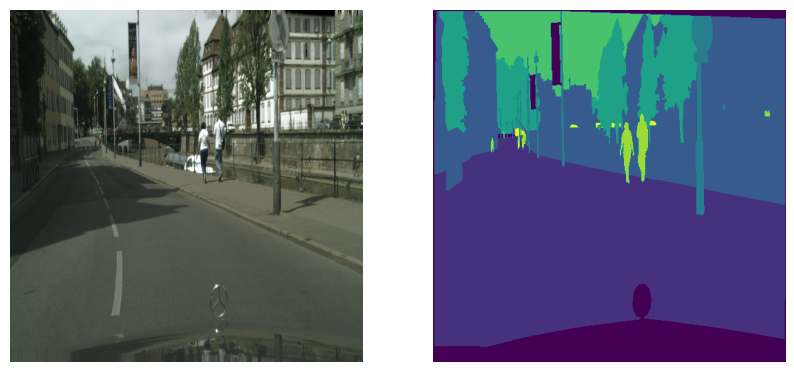

In [17]:
id_list = [0, 10, 50, 100, 105, 3]
#sns.set_theme(style="white", palette=None)
utils.display_image_n_mask(dat_train, id_list, IMAGE_SIZE)

In [18]:
stop

NameError: name 'stop' is not defined

# Unet

In [ ]:
unet_model = UNet(n_channels=3, n_classes=8)
unet_model = unet_model.to(device)

In [ ]:
total_params = sum(p.numel() for p in unet_model.parameters())
total_params_trainable = sum(p.numel() for p in unet_model.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  31038088
Number of trainable parameters:  31038088


In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3) 

history = train_model(unet_model, load_train, load_val, device, optimizer, 
                        epochs=EPOCHS, batch_size=BATCH_SIZE, debug=False, patience=3, use_scheduler=False)

Epoch 1/20:   2%|▏         | 68/2953 [01:16<51:56,  1.08s/img, IoU (batch)=0.309, loss (batch)=1.01]  Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002D2E7434690>>
Traceback (most recent call last):
  File "d:\Projects\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Epoch 1/20:   3%|▎         | 80/2953 [01:29<52:07,  1.09s/img, IoU (batch)=0.177, loss (batch)=1.14] 

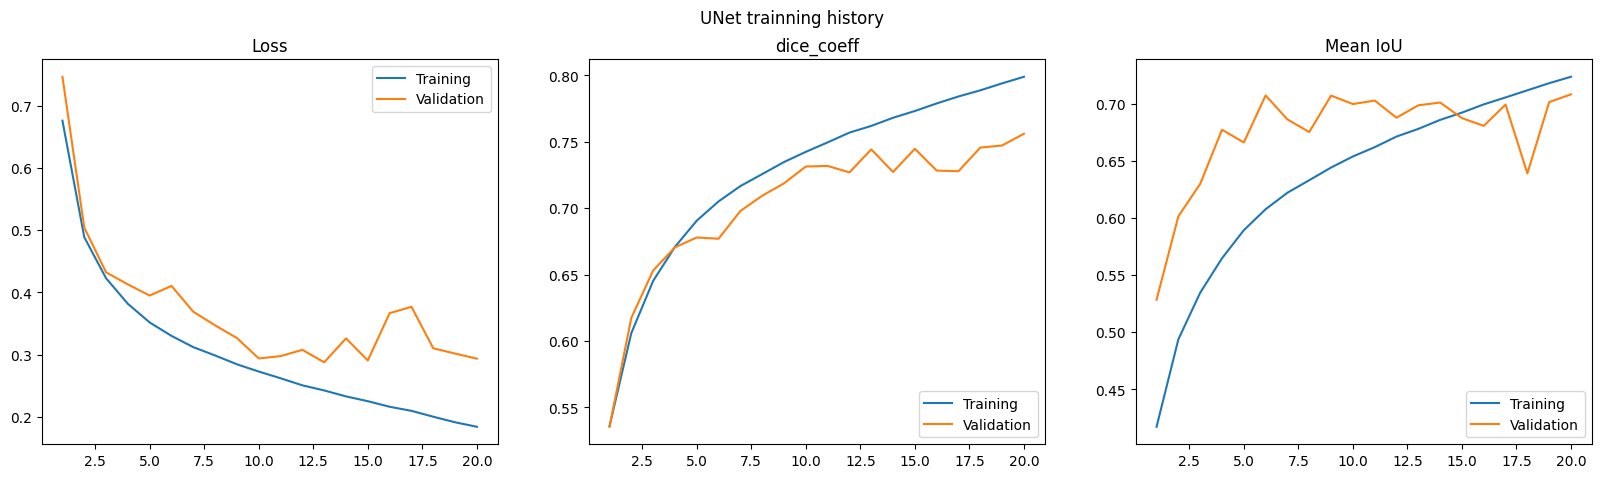

In [ ]:
utils.plot_model(history, "UNet trainning history")

In [ ]:
unet_model = Load_Checkpoint(unet_model, device)
score_test, cm = evaluate(unet_model, load_test, device)

In [ ]:
print(score_test['dice'])

0.7572630671144441


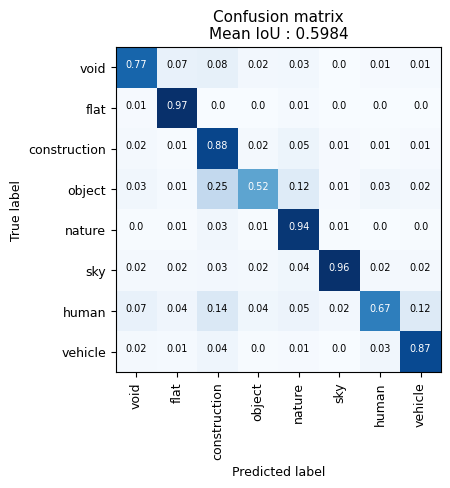

In [ ]:
utils.plot_confusion_matrix(cm, score_test['IoU'])

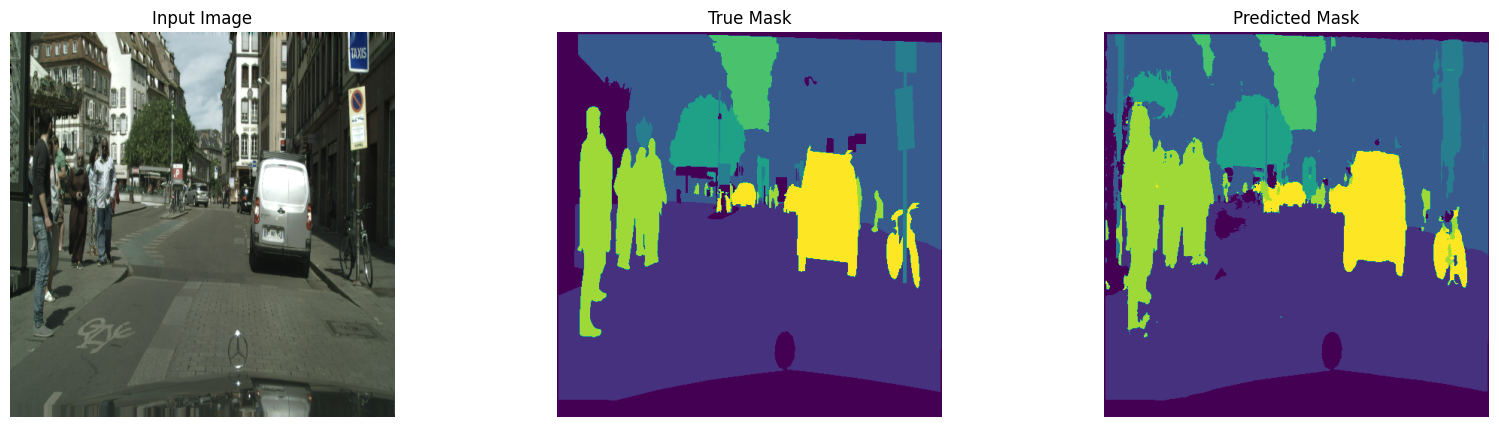

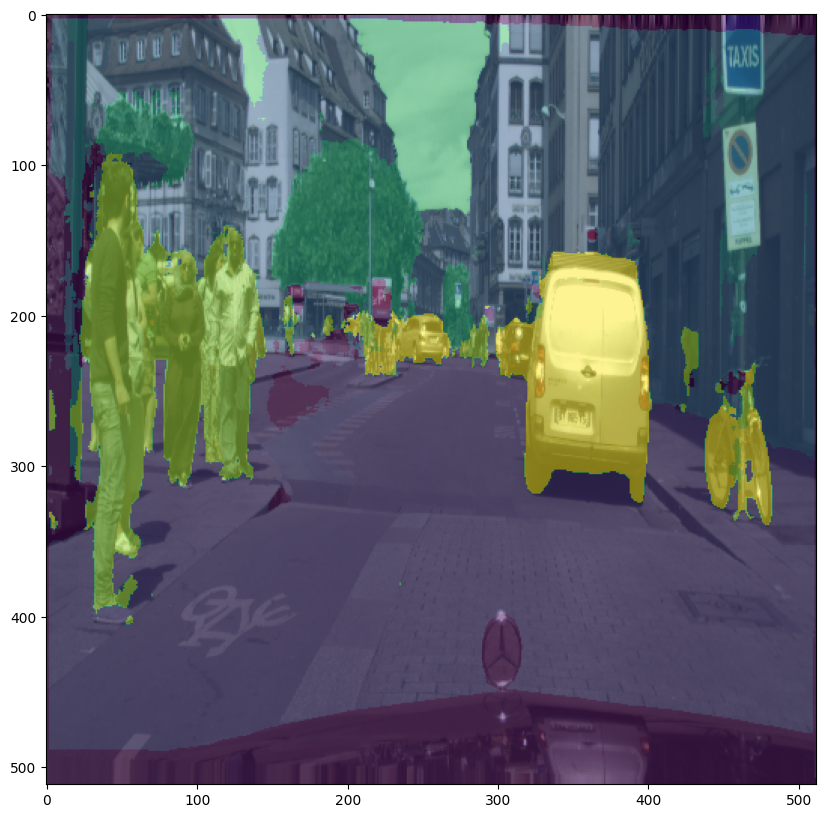

In [ ]:
id = 10
img, mask = dat_train[id]['image'], dat_train[id]['mask']
pred = infer_one_image(unet_model, device, img)

utils.superpose_image_mask_pred(img, mask, pred, IMAGE_SIZE)

In [ ]:
stop

# SegFormer

In [19]:
class SegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model, mit_scale
        ):
        super(SegmentationModel, self).__init__()
        self.n_channels = 3
        self.n_classes = 8
        self.name = f"SegFormer_HuggingFace_mit{mit_scale}"
        self.model = model
        
    def forward(self, image):
        outputs = self.model(pixel_values=image)
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=IMAGE_SIZE, 
            mode="bilinear",
            align_corners=False
        )
        
        return upsampled_logits

## B3

In [20]:
SAMPLE_SIZE = 1
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 2
EPOCHS = 20

dat_train = CSDataset(full_dict['train'], IMAGE_SIZE, augmentation=None)
dat_val = CSDataset(full_dict['val'], IMAGE_SIZE, augmentation=None)
dat_test = CSDataset(full_dict['test'], IMAGE_SIZE, augmentation=None)

load_train = DataLoader(dat_train, batch_size=BATCH_SIZE)
load_val = DataLoader(dat_val, batch_size=BATCH_SIZE)
load_test = DataLoader(dat_test, batch_size=BATCH_SIZE)

In [21]:
#https://huggingface.co/nvidia/mit-b3
segFormer_huggingFace_b3 = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b3",
        ignore_mismatched_sizes=True,
        num_labels=8,
        reshape_last_stage=True
    )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = SegmentationModel(segFormer_huggingFace_b3, "b3")

dummy_tensor = torch.randn((1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
segmentation = model(dummy_tensor)

segformer = model.to(device)

segmentation.shape

torch.Size([1, 8, 512, 512])

In [ ]:
total_params = sum(p.numel() for p in segformer.parameters())
total_params_trainable = sum(p.numel() for p in segformer.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  47228616
Number of trainable parameters:  47228616


In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#optimizer = torch.optim.Adam(segformer.parameters(), lr=1e-3) 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

history = train_model(segformer, load_train, load_val, device, optimizer, epochs=EPOCHS,
                        batch_size=BATCH_SIZE, debug=False, use_scheduler=False)

Epoch 1/20: 100%|██████████| 2953/2953 [18:53<00:00,  2.61img/s, IoU (batch)=0.364, loss (batch)=0.172] 


Epoch 1 --> train loss :0.2942026031475335 | train IoU : 0.6371062858008506 | train dice : 0.7451730571894042


0.7834748712204794 Val Dice score is better than previous -inf, saving checkpoint epoch:  1


Epoch 2/20: 100%|██████████| 2953/2953 [18:55<00:00,  2.60img/s, IoU (batch)=0.346, loss (batch)=0.11]  


Epoch 2 --> train loss :0.20733494161247965 | train IoU : 0.6991039303466628 | train dice : 0.7973535288485951


0.7888309391400287 Val Dice score is better than previous 0.7834748712204794, saving checkpoint epoch:  2


Epoch 3/20: 100%|██████████| 2953/2953 [18:54<00:00,  2.60img/s, IoU (batch)=0.348, loss (batch)=0.0809]


Epoch 3 --> train loss :0.17629128454420803 | train IoU : 0.7215120175771328 | train dice : 0.815511425847368


0.803590148459864 Val Dice score is better than previous 0.7888309391400287, saving checkpoint epoch:  3


Epoch 4/20: 100%|██████████| 2953/2953 [30:50<00:00,  1.60img/s, IoU (batch)=0.357, loss (batch)=0.0718]  


Epoch 4 --> train loss :0.1500202026508229 | train IoU : 0.7385686419355231 | train dice : 0.8299329960435003


0.8068177317845002 Val Dice score is better than previous 0.803590148459864, saving checkpoint epoch:  4


Epoch 5/20: 100%|██████████| 2953/2953 [19:55<00:00,  2.47img/s, IoU (batch)=0.347, loss (batch)=0.0627]


Epoch 5 --> train loss :0.13460900923066957 | train IoU : 0.7508405158427746 | train dice : 0.8385057701157329


0.8111044031973104 Val Dice score is better than previous 0.8068177317845002, saving checkpoint epoch:  5


Epoch 6/20: 100%|██████████| 2953/2953 [19:35<00:00,  2.51img/s, IoU (batch)=0.355, loss (batch)=0.0664]


Epoch 6 --> train loss :0.12202293131205386 | train IoU : 0.7610427118115962 | train dice : 0.8467618390847157


0.8126481034373509 Val Dice score is better than previous 0.8111044031973104, saving checkpoint epoch:  6


Epoch 7/20: 100%|██████████| 2953/2953 [19:38<00:00,  2.50img/s, IoU (batch)=0.36, loss (batch)=0.0583] 


Epoch 7 --> train loss :0.11112518401245208 | train IoU : 0.7701256907349157 | train dice : 0.8541592008452522


Epoch 8/20: 100%|██████████| 2953/2953 [19:39<00:00,  2.50img/s, IoU (batch)=0.358, loss (batch)=0.0536]


Epoch 8 --> train loss :0.10418391341221195 | train IoU : 0.776912841577503 | train dice : 0.8603116437722157


0.815340114913824 Val Dice score is better than previous 0.8126481034373509, saving checkpoint epoch:  8


Epoch 9/20: 100%|██████████| 2953/2953 [19:04<00:00,  2.58img/s, IoU (batch)=0.359, loss (batch)=0.0543]


Epoch 9 --> train loss :0.09764227288987641 | train IoU : 0.7836818174114776 | train dice : 0.8650742042040453


0.8201376063223104 Val Dice score is better than previous 0.815340114913824, saving checkpoint epoch:  9


Epoch 10/20: 100%|██████████| 2953/2953 [18:48<00:00,  2.62img/s, IoU (batch)=0.36, loss (batch)=0.0529] 


Epoch 10 --> train loss :0.09514626007610345 | train IoU : 0.7888040564922943 | train dice : 0.8692118671187373


0.8209589601473044 Val Dice score is better than previous 0.8201376063223104, saving checkpoint epoch:  10


Epoch 11/20: 100%|██████████| 2953/2953 [18:57<00:00,  2.60img/s, IoU (batch)=0.372, loss (batch)=0.0463]


Epoch 11 --> train loss :0.08869719165947967 | train IoU : 0.79391389311626 | train dice : 0.8739637660269973


Epoch 12/20: 100%|██████████| 2953/2953 [19:40<00:00,  2.50img/s, IoU (batch)=0.364, loss (batch)=0.0494]


Epoch 12 --> train loss :0.08547710392374441 | train IoU : 0.7983886280330911 | train dice : 0.8773597505501015


Epoch 13/20: 100%|██████████| 2953/2953 [19:50<00:00,  2.48img/s, IoU (batch)=0.382, loss (batch)=0.0481]


Epoch 13 --> train loss :0.08294640162035308 | train IoU : 0.8021181299535999 | train dice : 0.8804803537047224


Epoch 14/20: 100%|██████████| 2953/2953 [19:43<00:00,  2.50img/s, IoU (batch)=0.368, loss (batch)=0.0472]


Epoch 14 --> train loss :0.08104091274224792 | train IoU : 0.8054255514688551 | train dice : 0.8824871995599187


0.822094808098014 Val Dice score is better than previous 0.8209589601473044, saving checkpoint epoch:  14


Epoch 15/20: 100%|██████████| 2953/2953 [19:48<00:00,  2.48img/s, IoU (batch)=0.379, loss (batch)=0.0463]


Epoch 15 --> train loss :0.07934578339655655 | train IoU : 0.8075466332055526 | train dice : 0.8851953091941012


Epoch 16/20: 100%|██████████| 2953/2953 [18:48<00:00,  2.62img/s, IoU (batch)=0.376, loss (batch)=0.0432]


Epoch 16 --> train loss :0.07827742675605584 | train IoU : 0.8087578862588186 | train dice : 0.8858696298980197


Epoch 17/20: 100%|██████████| 2953/2953 [18:47<00:00,  2.62img/s, IoU (batch)=0.379, loss (batch)=0.0412]


Epoch 17 --> train loss :0.0780937004703259 | train IoU : 0.8093757228082112 | train dice : 0.8871948820719787


Epoch 18/20: 100%|██████████| 2953/2953 [18:53<00:00,  2.60img/s, IoU (batch)=0.382, loss (batch)=0.0476]


Epoch 18 --> train loss :0.08334642758412626 | train IoU : 0.8054113426106109 | train dice : 0.8852509309410969


Early stoping at epoch  18


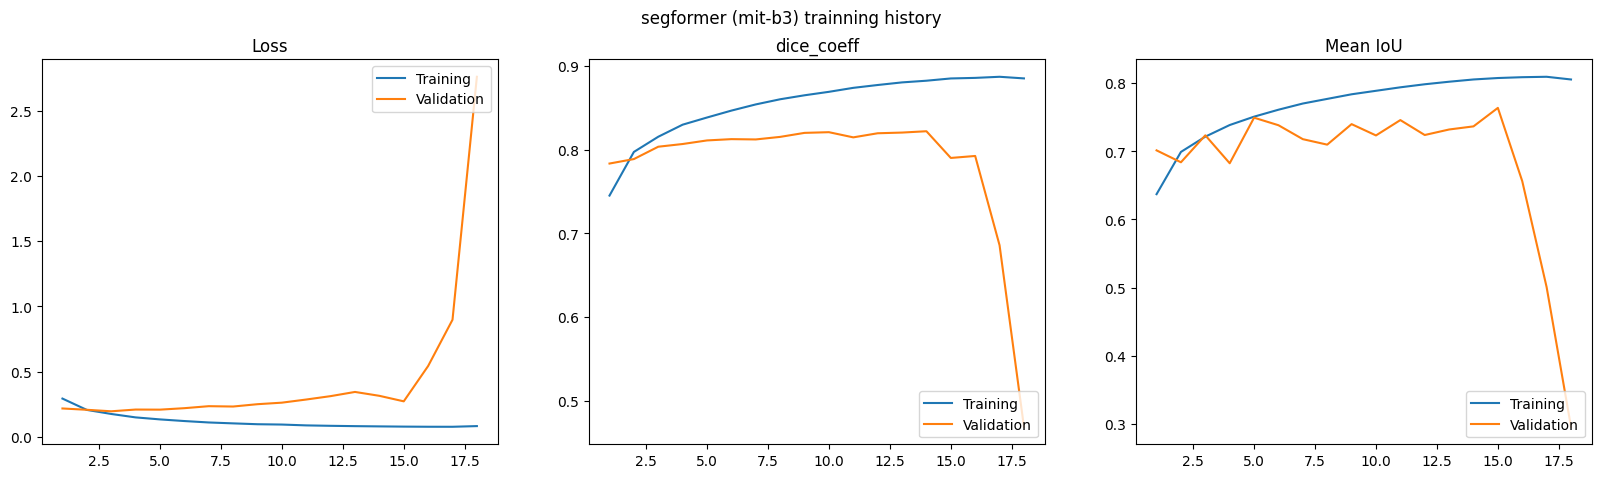

In [ ]:
utils.plot_model(history, "segformer (mit-b3) trainning history")

In [ ]:
segformer = Load_Checkpoint(segformer, device)
score_test, cm = evaluate(segformer, load_test, device)

In [ ]:
print(score_test['dice'])

0.8202562987349415


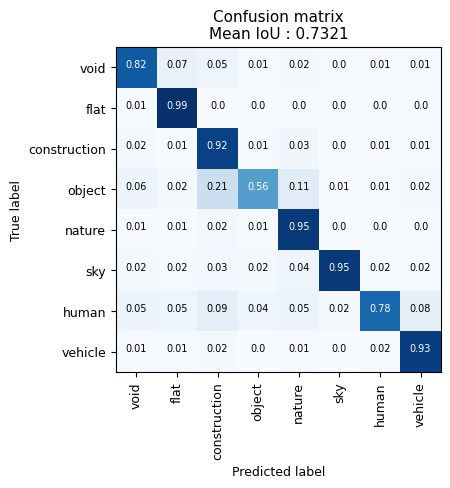

In [ ]:
utils.plot_confusion_matrix(cm, mean_ioU=score_test['IoU'])

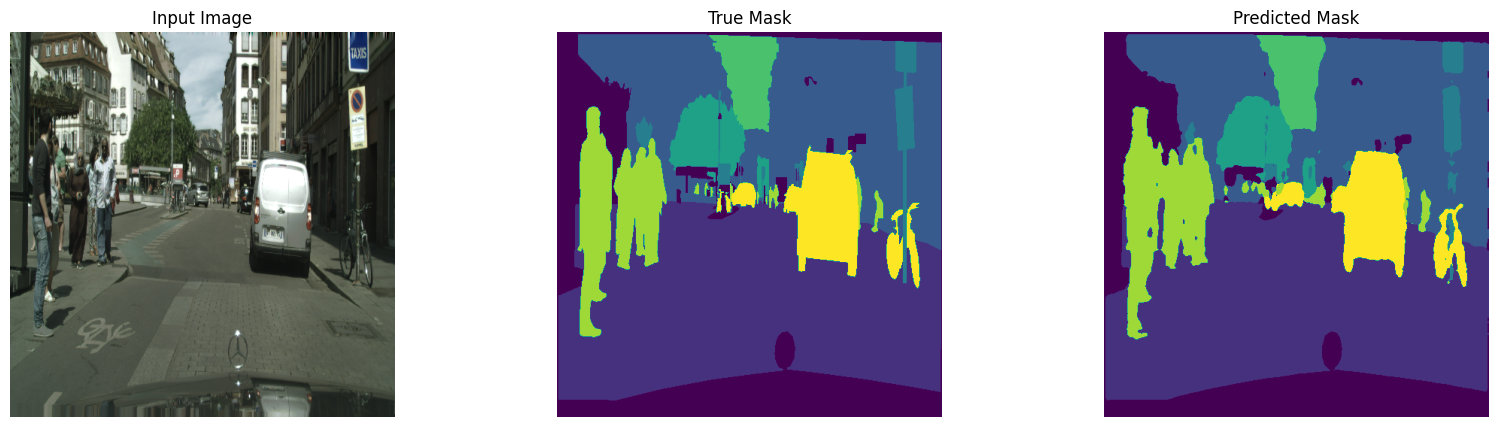

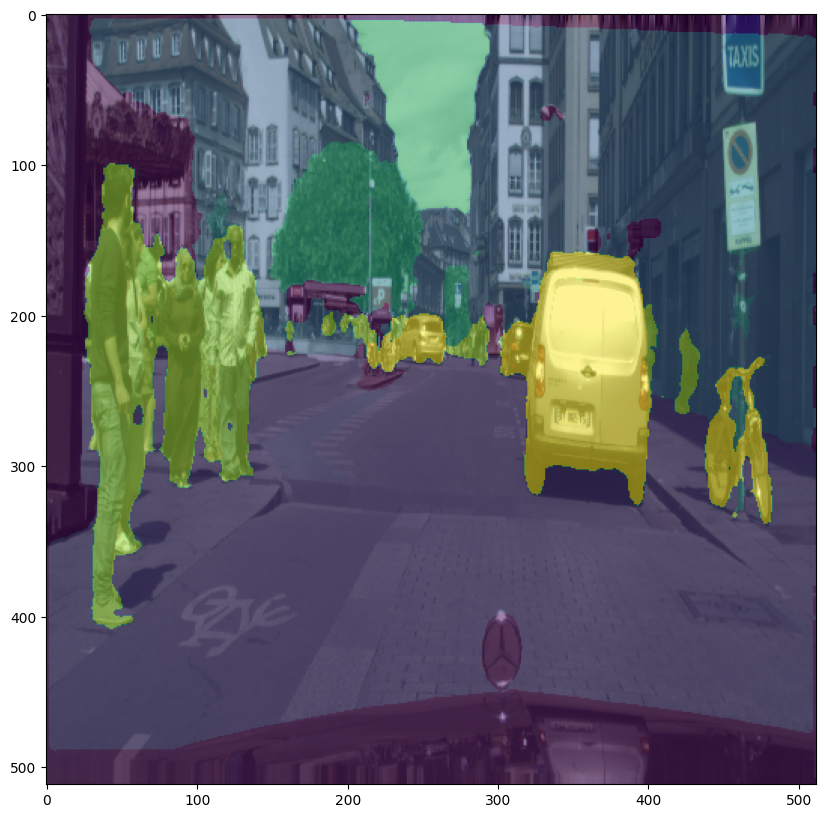

In [ ]:
id = 10
img, mask = dat_train[id]['image'], dat_train[id]['mask']
pred = infer_one_image(segformer, device, img)

utils.superpose_image_mask_pred(img, mask, pred, IMAGE_SIZE)